In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from keras.layers import Activation, Reshape, Dropout
from keras.layers import AtrousConvolution2D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
from keras import regularizers

import tensorflow as tf 

from scipy.misc import imresize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from PIL import Image

from keras.preprocessing.image import array_to_img , img_to_array , load_img ,ImageDataGenerator 

from subprocess import check_output
#print (check_output(["ls", "../myproject"]).decode("utf8"))

Using TensorFlow backend.


In [2]:
data_dir = "train/"
mask_dir = "train_masks/"
all_images = os.listdir(data_dir)

In [3]:
train_images, validation_images = train_test_split(all_images, train_size=0.8, test_size=0.2)
print len(train_images)
#content_image=Image.open('train/fc5f1a3a66cf_06.jpg')
#content_image.size

4070


In [4]:
def grey2rgb_2(img):
    new_img=np.array(list(img)*3)
    new_img=new_img.reshape(img.shape[0],img.shape[1],3)
    return new_img

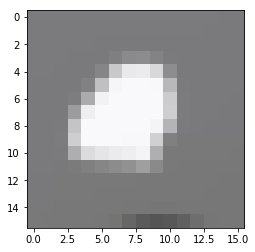

In [5]:
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        """
        while True:
            batch = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in batch:
                # images
                original_img = load_img(data_dir + images[i])
                resized_img = imresize(original_img, dims+[3])
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
                
                # masks
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
                resized_mask = imresize(original_mask,[dims[0]/8,dims[1]/8,3])
                array_mask = img_to_array(resized_mask)/255
                labels.append(array_mask[:, :, 0])
            imgs = np.array(imgs)
            labels = np.array(labels)
            #print labels
            yield imgs, labels.reshape(-1, dims[0]/8, dims[1]/8, 1)

# example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, 5, [128, 128])
img, msk = next(train_gen)

plt.imshow(img[0])
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

In [6]:
def down(input_layers,filters,pool=True):
    conv1=Conv2D(filters,(2,2),padding="same",activation='relu')(input_layers)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    return conv2

In [7]:
def get_frontend(input_width, input_height):
    model = Sequential()
    # model.add(ZeroPadding2D((1, 1), input_shape=(input_width, input_height, 3)))
    model.add(Convolution2D(64,(3,3),padding='same', activation='relu', name='conv1_1', input_shape=(input_width, input_height, 3)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Convolution2D(128,(3,3), padding='same',activation='relu', name='conv2_1'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Convolution2D(256,(3,3),padding='same',activation='relu', name='conv3_1'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(512,(3,3), padding='same',activation='relu', name='conv4_1'))

    # Compared to the original VGG16, we skip the next 2 MaxPool layers,
    # and go ahead with dilated convolutional layers instead

    model.add(AtrousConvolution2D(512, 3, 3, atrous_rate=(2, 2), activation='relu', name='conv5_1'))
    #model.add(AtrousConvolution2D(512, 3, 3, atrous_rate=(2, 2), activation='relu', name='conv5_2'))
    model.add(AtrousConvolution2D(512, 3, 3, atrous_rate=(2, 2), activation='relu', name='conv5_3'))

    # Compared to the VGG16, we replace the FC layer with a convolution

    model.add(AtrousConvolution2D(1024,3,3, atrous_rate=(2,2), activation='relu', name='fc6'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(1024, 1, 1, activation='relu', name='fc7'))
    model.add(Dropout(0.5))
    # Note: this layer has linear activations, not ReLU
    model.add(Convolution2D(21, 1, 1, activation='linear', name='fc-final'))

    # model.layers[-1].output_shape == (None, 16, 16, 21)
    return model


def add_softmax(model):
    """ Append the softmax layers to the frontend or frontend + context net. """
    # The softmax layer doesn't work on the (width, height, channel)
    # shape, so we reshape to (width*height, channel) first.
    # https://github.com/fchollet/keras/issues/1169
    _, curr_width, curr_height, curr_channels = model.layers[-1].output_shape

    model.add(Reshape((curr_width * curr_height, curr_channels)))
    model.add(Activation('softmax'))
    # Technically, we need another Reshape here to reshape to 2d, but TF
    # the complains when batch_size > 1. We're just going to reshape in numpy.
    # model.add(Reshape((curr_width, curr_height, curr_channels)))

    return model


def add_context(model):
    """ Append the context layers to the frontend. """
    model.add(ZeroPadding2D(padding=(33, 33)))
    model.add(Convolution2D(42, 3, 3, activation='relu', name='ct_conv1_1'))
    model.add(Convolution2D(42, 3, 3, activation='relu', name='ct_conv1_2'))
    model.add(AtrousConvolution2D(84, 3, 3, atrous_rate=(2, 2), activation='relu', name='ct_conv2_1'))
    model.add(AtrousConvolution2D(168, 3, 3, atrous_rate=(4, 4), activation='relu', name='ct_conv3_1'))
    model.add(AtrousConvolution2D(336, 3, 3, atrous_rate=(8, 8), activation='relu', name='ct_conv4_1'))
    model.add(AtrousConvolution2D(672, 3, 3, atrous_rate=(16, 16), activation='relu', name='ct_conv5_1'))
    model.add(Convolution2D(672, 3, 3, activation='relu', name='ct_fc1'))
    model.add(Convolution2D(21, 1, 1, name='ct_final'))

    return model

In [7]:
# Make a custom U-nets implementation.
filters = 64
input_layer = Input(shape = [128, 128, 3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2, 64
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3, 32
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4, 16
d5 = down(d3, filters, pool=False)

atr1=Conv2D(512,(3,3),dilation_rate=(2, 2),activation='relu',padding='same')(d5)
atr2=Conv2D(512,(3,3),dilation_rate=(2, 2),activation='relu',padding='same')(atr1)
atr3=Conv2D(512,(3,3),dilation_rate=(2, 2),activation='relu',padding='same')(atr2)

fc6=Conv2D(1024,(3,3),dilation_rate=(2, 2),activation='relu',padding='same')(atr3)

fc7=Dropout(0.5)(fc6)



out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(fc7)

model = Model(input_layer, out)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       32896     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
__________

In [13]:
input_width=128
input_height=input_width
input_layer = Input(shape = [128, 128, 3])
model = get_frontend(input_width, input_height)

model = add_softmax(model)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
conv4_1 (Conv2D)             (None, 16, 16, 512)       1180160   
__________

/home/saurabh/myproject/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1024, (1, 1), activation="relu", name="fc7")`
/home/saurabh/myproject/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(21, (1, 1), activation="linear", name="fc-final")`


In [8]:
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


In [9]:
model.compile(optimizer=Adam(1e-4), loss= bce_dice_loss, metrics=[dice_coeff])
model.fit_generator(train_gen, steps_per_epoch=100,epochs=30)

Epoch 1/30
100/100 [==============================] - 64s - loss: 0.5724 - dice_coeff: 0.6970    
Epoch 2/30
100/100 [==============================] - 53s - loss: 0.3090 - dice_coeff: 0.8355    
Epoch 3/30
100/100 [==============================] - 53s - loss: 0.2745 - dice_coeff: 0.8539    
Epoch 4/30
100/100 [==============================] - 49s - loss: 0.2479 - dice_coeff: 0.8697    
Epoch 5/30
100/100 [==============================] - 51s - loss: 0.2376 - dice_coeff: 0.8734    
Epoch 6/30
100/100 [==============================] - 53s - loss: 0.2281 - dice_coeff: 0.8776    
Epoch 7/30
100/100 [==============================] - 52s - loss: 0.2220 - dice_coeff: 0.8818    
Epoch 8/30
100/100 [==============================] - 48s - loss: 0.2200 - dice_coeff: 0.8823    
Epoch 9/30
100/100 [==============================] - 50s - loss: 0.2166 - dice_coeff: 0.8843    
Epoch 10/30
100/100 [==============================] - 53s - loss: 0.2160 - dice_coeff: 0.8849    
Epoch 11/30
100/100

KeyboardInterrupt: 

In [ ]:
#accuracy = model.evaluate(test_x, test_y, verbose=1)

In [ ]:
validation_gen = data_gen_small(data_dir, mask_dir, validation_images, 5, [128, 128])
img, msk = next(train_gen)

In [ ]:
model.evaluate_generator(validation_gen,100)

In [ ]:
def get_frontend(input_width, input_height):
    model = Sequential()
    # model.add(ZeroPadding2D((1, 1), input_shape=(input_width, input_height, 3)))
    model.add(Convolution2D(64,(3,3), activation='relu', name='conv1_1', input_shape=(input_width, input_height, 3)))
    model.add(Convolution2D(64,(3,3), 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Convolution2D(128,(3,3), activation='relu', name='conv2_1'))
    model.add(Convolution2D(128,(3,3), 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Convolution2D(256,(3,3), activation='relu', name='conv3_1'))
    model.add(Convolution2D(256, (3,3), activation='relu', name='conv3_2'))
    model.add(Convolution2D(256, (3,3) , activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Convolution2D(512,(3,3), activation='relu', name='conv4_1'))
    model.add(Convolution2D(512,(3,3), activation='relu', name='conv4_2'))
    model.add(Convolution2D(512,(3,3), activation='relu', name='conv4_3'))

    # Compared to the original VGG16, we skip the next 2 MaxPool layers,
    # and go ahead with dilated convolutional layers instead

    model.add(AtrousConvolution2D(512, 3, 3, atrous_rate=(2, 2), activation='relu', name='conv5_1'))
    model.add(AtrousConvolution2D(512, 3, 3, atrous_rate=(2, 2), activation='relu', name='conv5_2'))
    model.add(AtrousConvolution2D(512, 3, 3, atrous_rate=(2, 2), activation='relu', name='conv5_3'))

    # Compared to the VGG16, we replace the FC layer with a convolution

    model.add(AtrousConvolution2D(4096, 7, 7, atrous_rate=(2, 2), activation='relu', name='fc6'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, 1, 1, activation='relu', name='fc7'))
    model.add(Dropout(0.5))
    # Note: this layer has linear activations, not ReLU
    model.add(Convolution2D(21, 1, 1, activation='linear', name='fc-final'))

    # model.layers[-1].output_shape == (None, 16, 16, 21)
    return model


def add_softmax(model):
    """ Append the softmax layers to the frontend or frontend + context net. """
    # The softmax layer doesn't work on the (width, height, channel)
    # shape, so we reshape to (width*height, channel) first.
    # https://github.com/fchollet/keras/issues/1169
    _, curr_width, curr_height, curr_channels = model.layers[-1].output_shape

    model.add(Reshape((curr_width * curr_height, curr_channels)))
    model.add(Activation('softmax'))
    # Technically, we need another Reshape here to reshape to 2d, but TF
    # the complains when batch_size > 1. We're just going to reshape in numpy.
    # model.add(Reshape((curr_width, curr_height, curr_channels)))

    return model


def add_context(model):
    """ Append the context layers to the frontend. """
    model.add(ZeroPadding2D(padding=(33, 33)))
    model.add(Convolution2D(42, 3, 3, activation='relu', name='ct_conv1_1'))
    model.add(Convolution2D(42, 3, 3, activation='relu', name='ct_conv1_2'))
    model.add(AtrousConvolution2D(84, 3, 3, atrous_rate=(2, 2), activation='relu', name='ct_conv2_1'))
    model.add(AtrousConvolution2D(168, 3, 3, atrous_rate=(4, 4), activation='relu', name='ct_conv3_1'))
    model.add(AtrousConvolution2D(336, 3, 3, atrous_rate=(8, 8), activation='relu', name='ct_conv4_1'))
    model.add(AtrousConvolution2D(672, 3, 3, atrous_rate=(16, 16), activation='relu', name='ct_conv5_1'))
    model.add(Convolution2D(672, 3, 3, activation='relu', name='ct_fc1'))
    model.add(Convolution2D(21, 1, 1, name='ct_final'))

    return model